<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/hyougo/hyougo_yousei_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
!pip install japanize-matplotlib

In [149]:
import pathlib
import re
from urllib.parse import urljoin

In [150]:
import requests
from bs4 import BeautifulSoup

# スクレイピング

In [151]:
def get_excel(url):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, "html.parser")
    tag = soup.find("a", href=re.compile("xls[mx]?$"))

    if tag:
        link = urljoin(url, tag.get("href"))
        p = get_file(link, "data")

        return p
    else:
        raise FileNotFoundError("Excelファイルが見つかりません")

In [152]:
def get_file(url, dir="."):
    
    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [153]:
import pandas as pd

In [154]:
p = get_excel("https://web.pref.hyogo.lg.jp/kk03/corona_kanjyajyokyo.html")

df_kanja = pd.read_excel(
    p,
    skiprows=3,
    skipfooter=2,
    usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    dtype={"番号": "Int64"},
)

In [155]:
df_kanja.shape

(1665, 10)

In [156]:
df_kanja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   番号      1663 non-null   Int64 
 1   発表日     1663 non-null   object
 2   年代      1663 non-null   object
 3   性別      1663 non-null   object
 4   管轄      1663 non-null   object
 5   居住地     1663 non-null   object
 6   職業      1662 non-null   object
 7   発症日     1663 non-null   object
 8   渡航歴     1663 non-null   object
 9   備考欄     1662 non-null   object
dtypes: Int64(1), object(9)
memory usage: 131.8+ KB


In [157]:
df_kanja.count()

番号     1663
発表日    1663
年代     1663
性別     1663
管轄     1663
居住地    1663
職業     1662
発症日    1663
渡航歴    1663
備考欄    1662
dtype: int64

# 前処理

In [158]:
import datetime

import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates
import numpy as np

In [159]:
# 解像度
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [160]:
# 全列欠損を削除

df_kanja.dropna(how="all", inplace=True)

In [161]:
# 発表日

flg_is_serial = df_kanja["発表日"].astype("str").str.isdigit()

fromSerial = pd.to_datetime(
    df_kanja.loc[flg_is_serial, "発表日"].astype(float),
    unit="D",
    origin=pd.Timestamp("1899/12/30"),
)
fromString = pd.to_datetime(df_kanja.loc[~flg_is_serial, "発表日"])

df_kanja["発表日"] = pd.concat([fromString, fromSerial])

In [162]:
# 除外
df_kanja.set_index("番号", inplace=True)
df_kanja.drop(738, inplace=True)

In [163]:
# 職業
df_kanja["職業"] = df_kanja["職業"].str.replace("\n", "")

In [164]:
# 備考欄

df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("\n", "")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("NO.|N0.|NO,|N0,|No,", "No.")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("・", "、")
df_kanja["備考欄"] = df_kanja["備考欄"].fillna("")

In [165]:
# ステータス

df_kanja["ステータス"] = df_kanja["発症日"].mask(df_kanja["発症日"].astype("str").str.isdigit(), "症状あり")

In [166]:
# 発症日

df_kanja["発症日"] = df_kanja["発症日"].where(df_kanja["発症日"].astype("str").str.isdigit())
df_kanja["発症日"] = pd.to_datetime(df_kanja["発症日"].astype(float), unit="D", origin=pd.Timestamp("1899/12/30"))

In [167]:
df_kanja.to_csv("kanja.tsv", sep="\t")

# 経過日数確認

## 経過日数グラフ

Text(0.98, 0.85, 'median: 6.0')

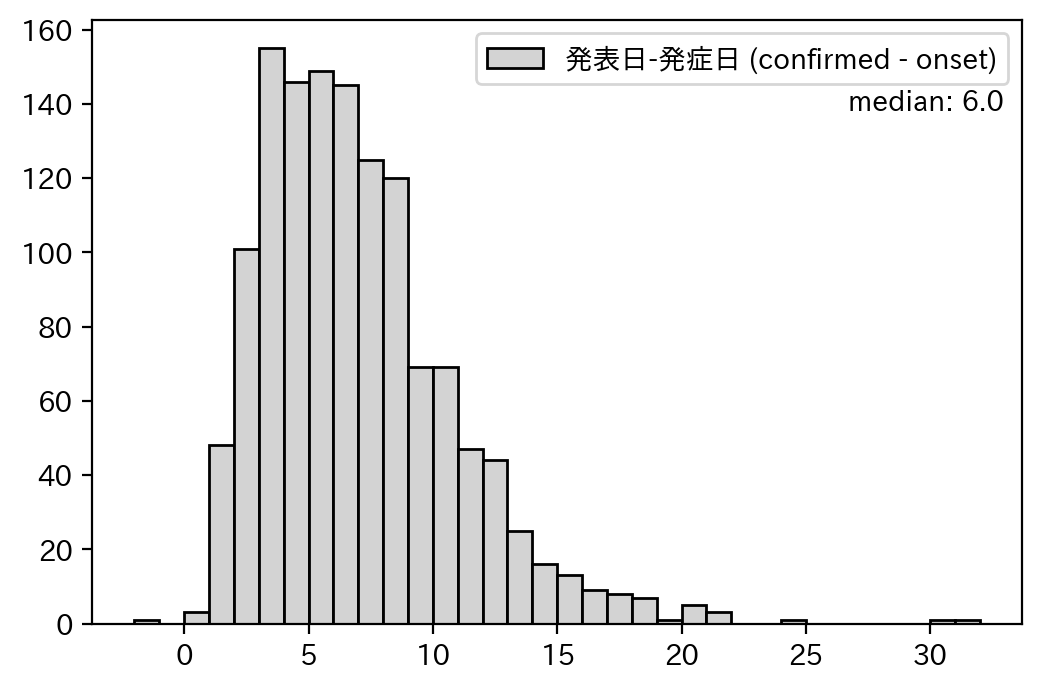

In [168]:
df_kanja["経過日数"] = (df_kanja["発表日"] - df_kanja["発症日"]).dt.days

df_kanja["経過日数"].dropna(inplace=True)

fig, ax = plt.subplots()
ax.hist(df_kanja["経過日数"], bins=np.arange(min(df_kanja["経過日数"]), max(df_kanja["経過日数"])+2), color="lightgray", edgecolor="black")
ax.legend(['発表日-発症日 (confirmed - onset)'])
ax.text(0.98, 0.85, 'median: ' + str(np.median(df_kanja["経過日数"])), horizontalalignment='right', transform=ax.transAxes)

## 経過日数一覧

In [169]:
df_kanja["経過日数"].value_counts().sort_index()

-2.0       1
 0.0       3
 1.0      48
 2.0     101
 3.0     155
 4.0     146
 5.0     149
 6.0     145
 7.0     125
 8.0     120
 9.0      69
 10.0     69
 11.0     47
 12.0     44
 13.0     25
 14.0     16
 15.0     13
 16.0      9
 17.0      8
 18.0      7
 19.0      1
 20.0      5
 21.0      3
 24.0      1
 30.0      1
 31.0      1
Name: 経過日数, dtype: int64

# 発症日グラフ

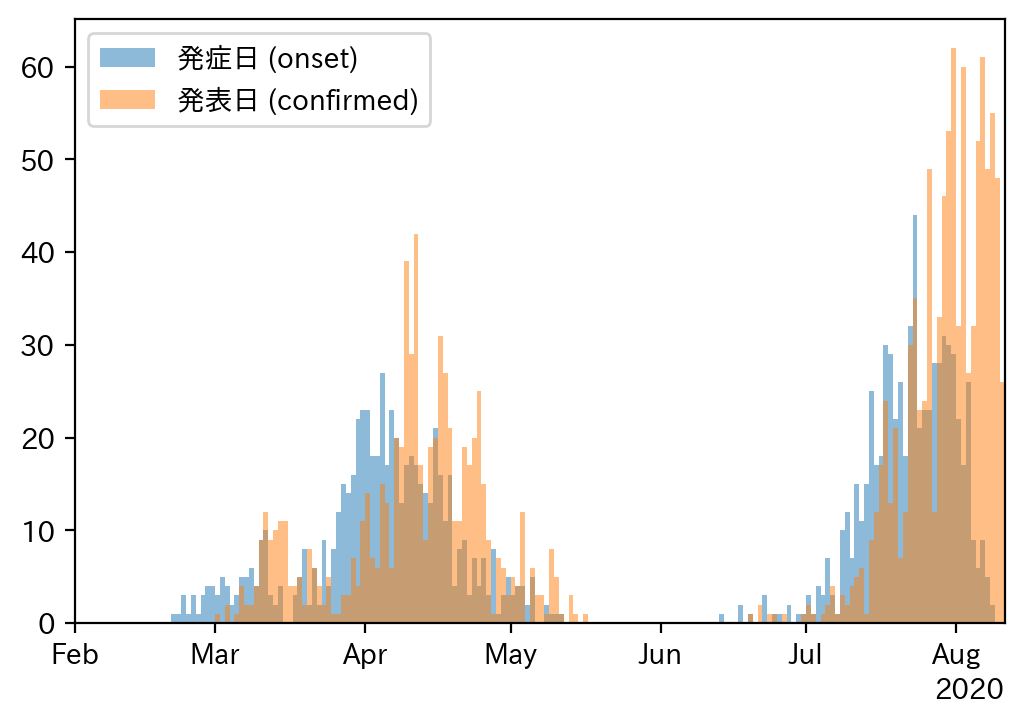

In [170]:
b = np.arange(min(min(df_kanja['発表日']), min(df_kanja['発症日'])),
              max(max(df_kanja['発表日']), max(df_kanja['発症日'])) + datetime.timedelta(days=2),
              datetime.timedelta(days=1))

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.hist(df_kanja['発症日'].values, bins=b, alpha=0.5) # edgecolor="black"
ax.hist(df_kanja['発表日'].values, bins=b, alpha=0.5)
ax.legend(['発症日 (onset)', '発表日 (confirmed)'])
ax.set_xlim(datetime.datetime(2020,2,1), b[-1])
fig.savefig('200312a.svg', bbox_inches="tight")

# 年代確認

## 年代別グラフ

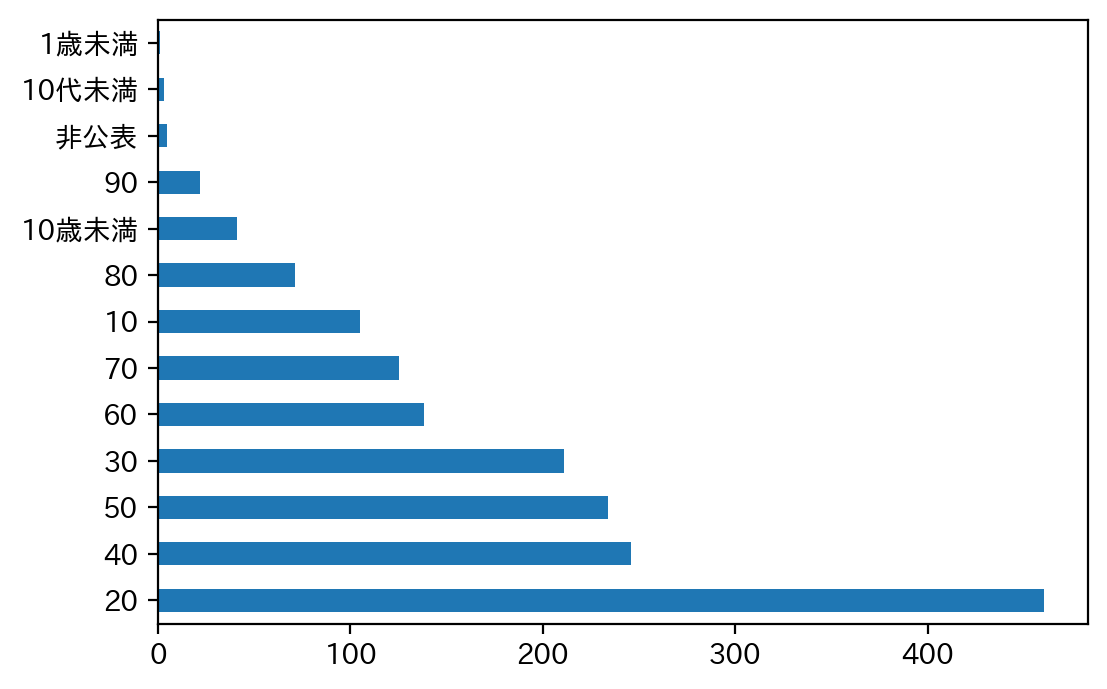

In [171]:
df_kanja["年代"].value_counts().plot.barh()

## 年代別一覧

In [172]:
df_kanja["年代"].value_counts()

20       460
40       246
50       234
30       211
60       138
70       125
10       105
80        71
10歳未満     41
90        22
非公表        5
10代未満      3
1歳未満       1
Name: 年代, dtype: int64

In [173]:
ages = ("非公表","10歳未満",10,20,30,40,50,60,70,80,90)

In [174]:
cr = pd.crosstab(df_kanja["発表日"], df_kanja["年代"], values=df_kanja["年代"], aggfunc="count").reindex(columns=ages).fillna(0).astype(int)
cr.tail(1)

年代,非公表,10歳未満,10,20,30,40,50,60,70,80,90
発表日,,,,,,,,,,,
2020-08-10,0,0,1,3,5,4,1,1,2,2,7


# 性別確認

## 性別別グラフ

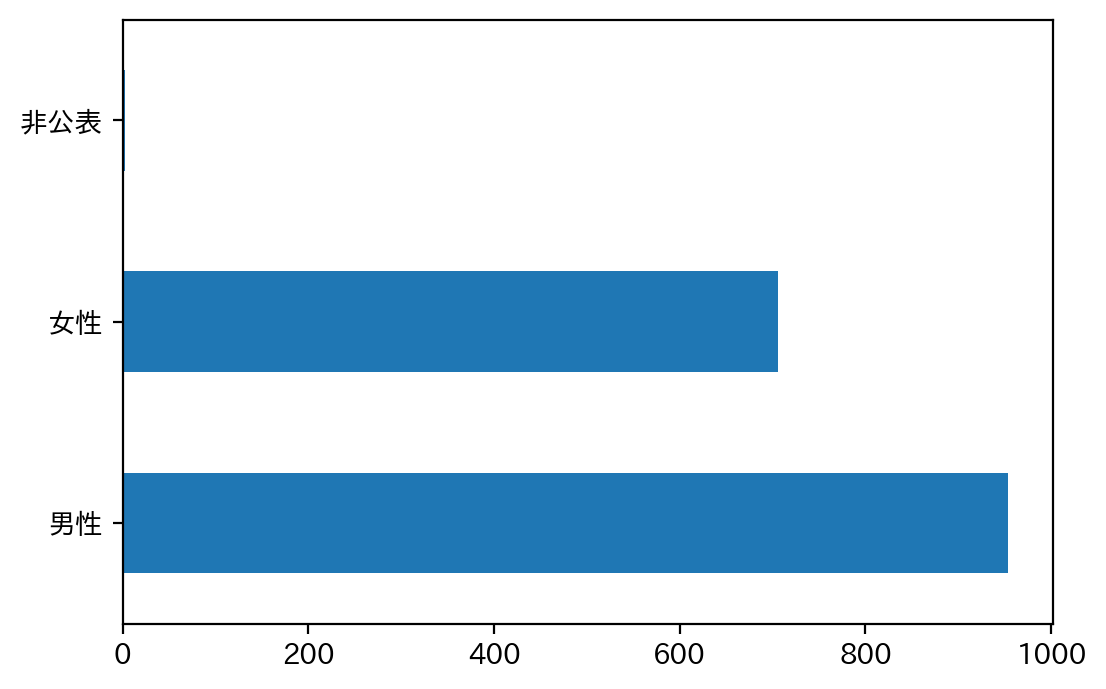

In [175]:
df_kanja["性別"].value_counts().plot.barh()

## 性別別一覧

In [176]:
df_kanja["性別"].value_counts()

男性     954
女性     706
非公表      2
Name: 性別, dtype: int64

# 居住地確認

## 居住地別グラフ

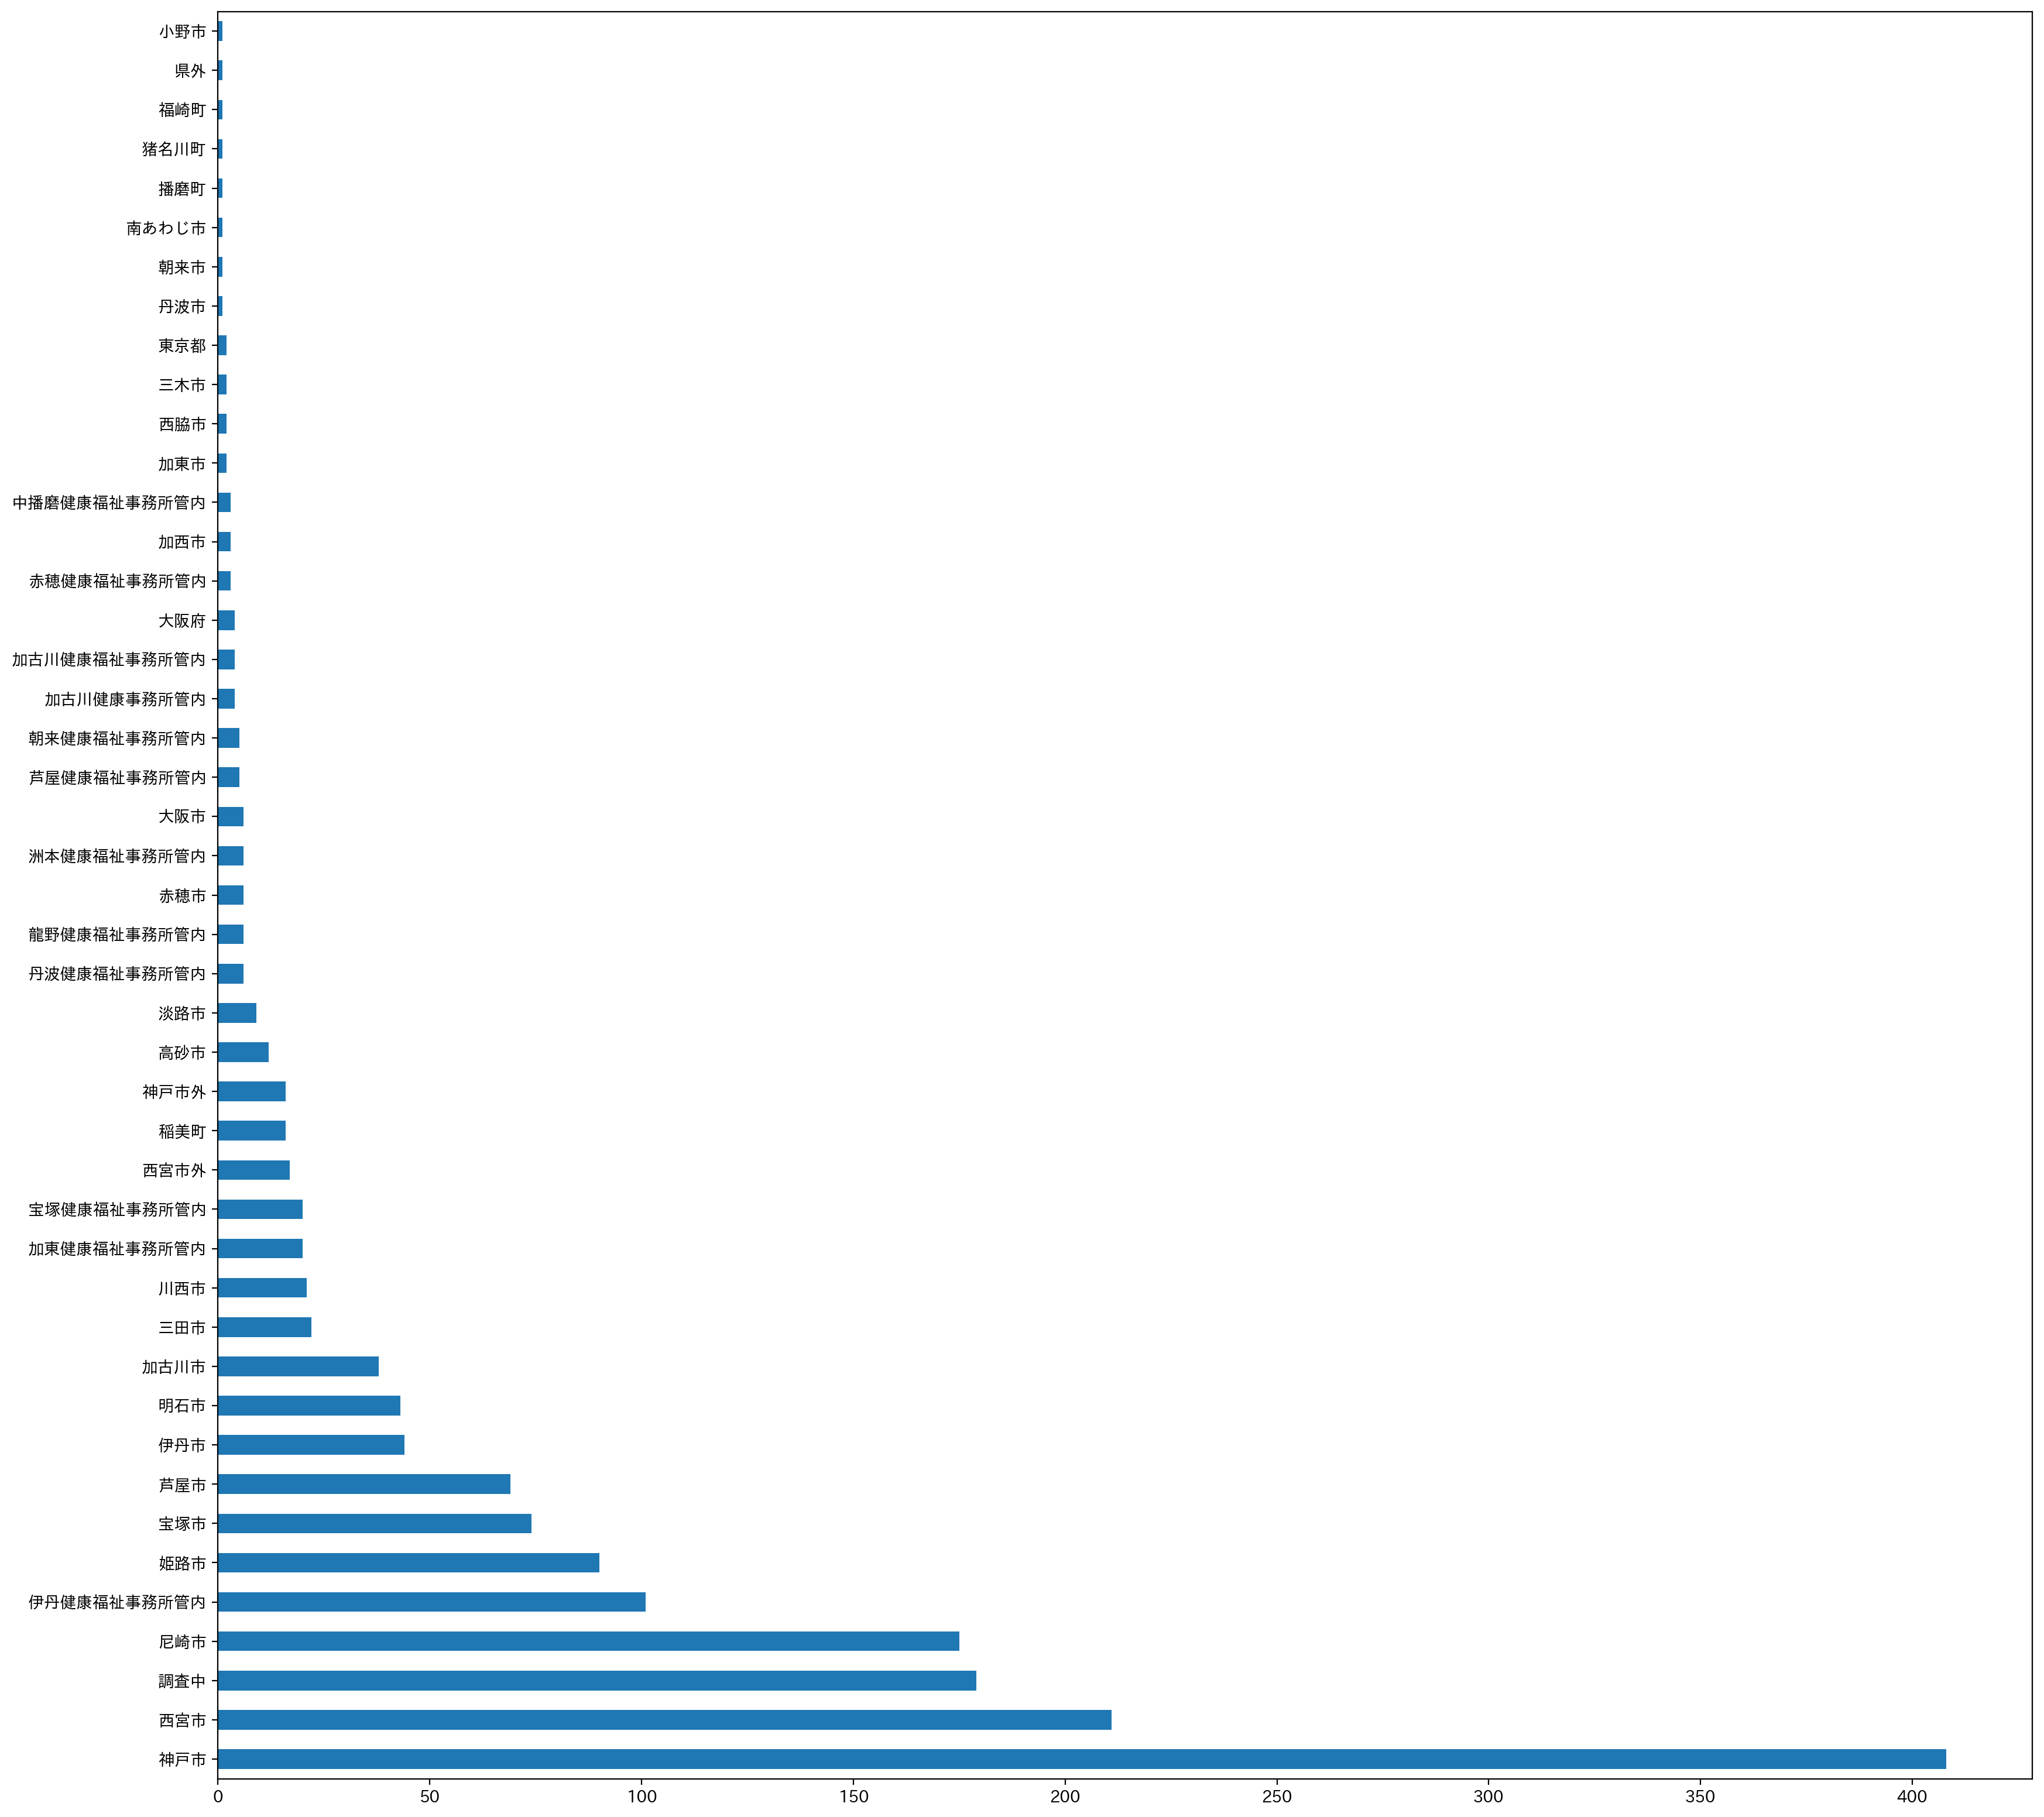

In [177]:
df_kanja["居住地"].value_counts().plot.barh(figsize=(20, 20))

## 居住地別一覧

In [178]:
df_kanja["居住地"].value_counts()

神戸市             408
西宮市             211
調査中             179
尼崎市             175
伊丹健康福祉事務所管内     101
姫路市              90
宝塚市              74
芦屋市              69
伊丹市              44
明石市              43
加古川市             38
三田市              22
川西市              21
加東健康福祉事務所管内      20
宝塚健康福祉事務所管内      20
西宮市外             17
稲美町              16
神戸市外             16
高砂市              12
淡路市               9
丹波健康福祉事務所管内       6
龍野健康福祉事務所管内       6
赤穂市               6
洲本健康福祉事務所管内       6
大阪市               6
芦屋健康福祉事務所管内       5
朝来健康福祉事務所管内       5
加古川健康事務所管内        4
加古川健康福祉事務所管内      4
大阪府               4
赤穂健康福祉事務所管内       3
加西市               3
中播磨健康福祉事務所管内      3
加東市               2
西脇市               2
三木市               2
東京都               2
丹波市               1
朝来市               1
南あわじ市             1
播磨町               1
猪名川町              1
福崎町               1
県外                1
小野市               1
Name: 居住地, dtype: int64

# 職業確認

## 職業別グラフ

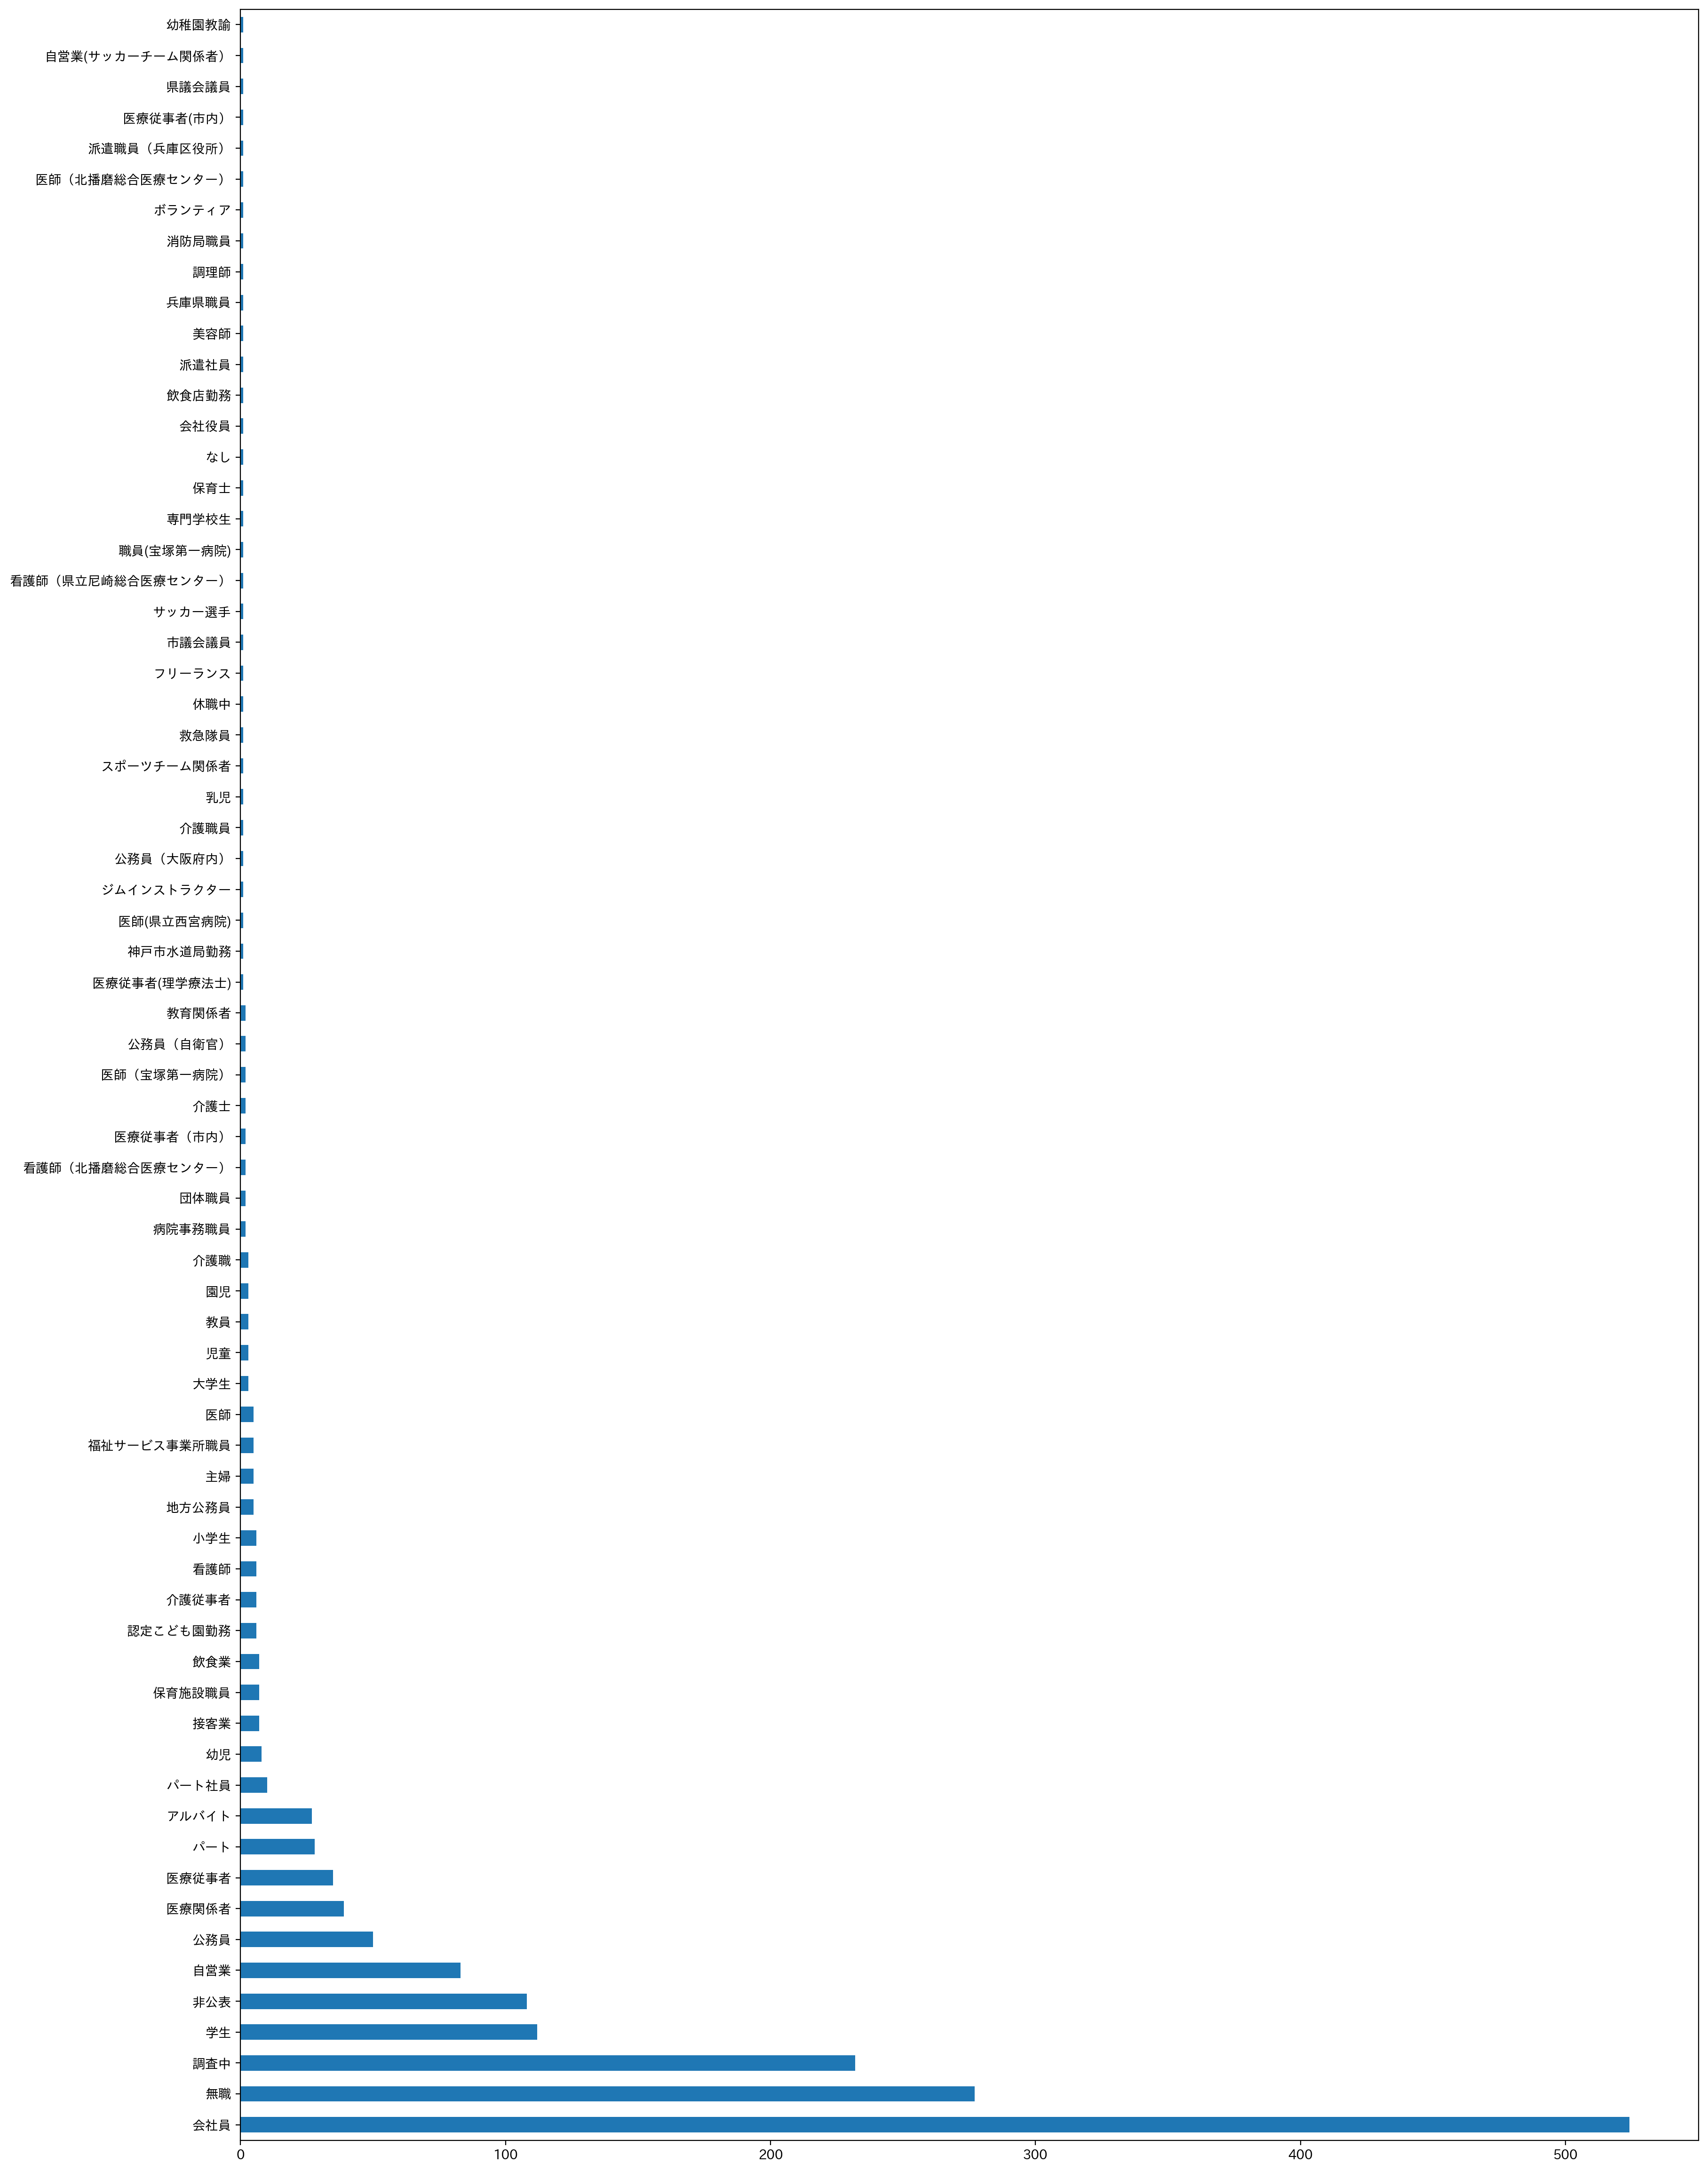

In [179]:
df_kanja["職業"].value_counts().plot.barh(figsize=(20, 30))

## 職業別一覧

In [180]:
df_kanja["職業"].value_counts()

会社員                524
無職                 277
調査中                232
学生                 112
非公表                108
                  ... 
派遣職員（兵庫区役所）          1
医療従事者(市内）            1
県議会議員                1
自営業(サッカーチーム関係者）      1
幼稚園教諭                1
Name: 職業, Length: 69, dtype: int64

# 管轄確認

## 管轄別グラフ

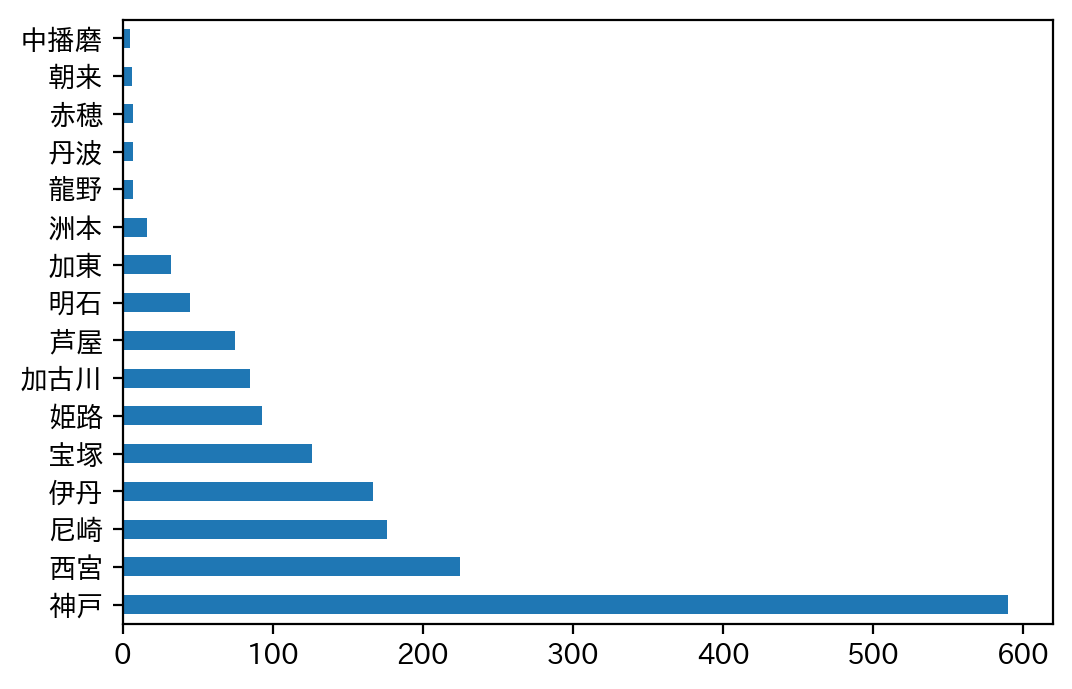

In [181]:
df_kanja["管轄"].value_counts().plot.barh()

## 管轄別一覧

In [182]:
df_kanja["管轄"].value_counts()

神戸     590
西宮     225
尼崎     176
伊丹     167
宝塚     126
姫路      93
加古川     85
芦屋      75
明石      45
加東      32
洲本      16
龍野       7
丹波       7
赤穂       7
朝来       6
中播磨      5
Name: 管轄, dtype: int64

# 最新

In [183]:
cr = pd.crosstab(df_kanja["発表日"], df_kanja["管轄"], values=df_kanja["管轄"], aggfunc="count").reindex(columns=["芦屋","宝塚","伊丹","加古川","加東","中播磨","龍野","赤穂","豊岡","朝来","丹波","洲本","神戸","姫路","尼崎","西宮","明石"]).fillna(0).astype(int)
cr.tail(1)

管轄,芦屋,宝塚,伊丹,加古川,加東,中播磨,龍野,赤穂,豊岡,朝来,丹波,洲本,神戸,姫路,尼崎,西宮,明石
発表日,,,,,,,,,,,,,,,,,
2020-08-10,0,0,1,0,0,0,1,0,0,0,0,0,17,0,0,5,2


In [184]:
cr.sum(axis=1).tail(1)

発表日
2020-08-10    26
dtype: int64

# 渡航歴確認

## 渡航歴別グラフ

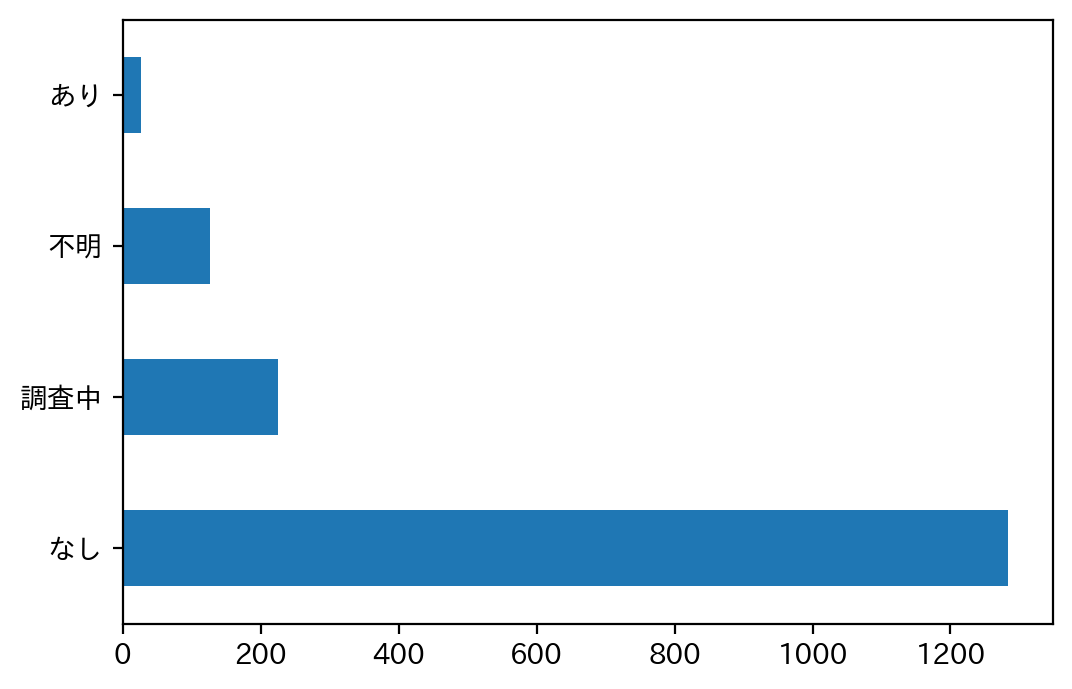

In [185]:
df_kanja["渡航歴"].value_counts().plot.barh()

## 渡航歴別一覧

In [186]:
df_kanja["渡航歴"].value_counts()

なし     1284
調査中     225
不明      127
あり       26
Name: 渡航歴, dtype: int64

# ステータス確認

## ステータス別グラフ

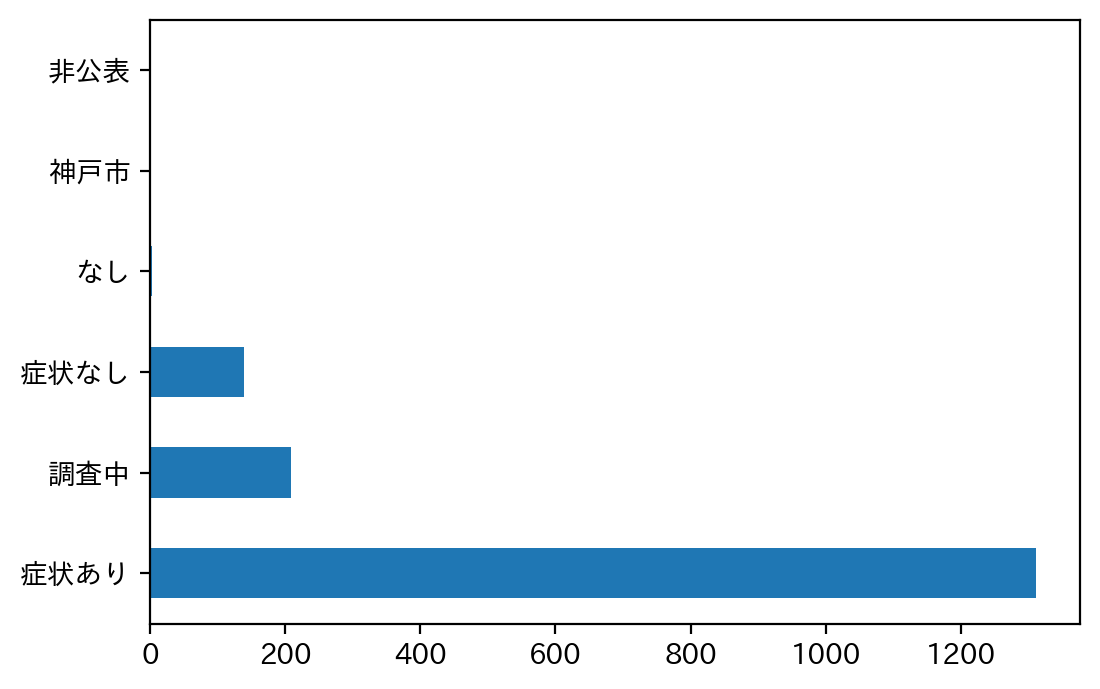

In [187]:
df_kanja["ステータス"].value_counts().plot.barh()

## ステータス別一覧

In [188]:
df_kanja["ステータス"].value_counts()

症状あり    1312
調査中      208
症状なし     138
なし         2
神戸市        1
非公表        1
Name: ステータス, dtype: int64

# 全体確認

In [189]:
df_kanja

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1663,2020-08-10,20,男性,龍野,龍野健康福祉事務所管内,非公表,2020-08-08,なし,大阪市の陽性患者の濃厚接触者,症状あり,2.0
1662,2020-08-10,40,女性,伊丹,伊丹健康福祉事務所管内,非公表,2020-08-06,なし,行動歴調査中,症状あり,4.0
1661,2020-08-10,60,男性,明石,明石市,無職,2020-08-03,なし,行動歴調査中,症状あり,7.0
1660,2020-08-10,20,女性,明石,明石市,非公表,2020-08-07,なし,行動歴調査中,症状あり,3.0
1659,2020-08-10,80,女性,西宮,西宮市,無職,2020-08-07,なし,尼崎市で発生した患者の濃厚接触者,症状あり,3.0
...,...,...,...,...,...,...,...,...,...,...,...
5,2020-03-06,40,男性,姫路,姫路市,会社員,2020-02-23,なし,2/19に大阪のSoap operaライブに参加,症状あり,12.0
4,2020-03-05,50,女性,中播磨,福崎町,無職,2020-02-22,なし,2/15、16に大阪のライブハウスArcに参加,症状あり,12.0
3,2020-03-03,40,女性,神戸,神戸市,会社員,2020-02-21,なし,2/15、16に大阪のライブハウスArcに参加,症状あり,11.0


# ファイル保存

In [190]:
import datetime

JST = datetime.timezone(datetime.timedelta(hours=+9))

dt_now = datetime.datetime.now(JST).date().isoformat()

## 全体

In [191]:
df_kanja.to_csv("kanja.tsv", sep="\t")

## 年齢別抽出

In [192]:
# 年齢別抽出

grouped_df = df_kanja.groupby("年代")

with pd.ExcelWriter(f"陽性者一覧（年齢別）_{dt_now}.xlsx", engine="openpyxl") as writer:

    for id in grouped_df.groups:

        d = grouped_df.get_group(id)

        # ExcelWriterを用いて新規シートにDataFrameを保存
        d.to_excel(writer, sheet_name=str(id), index=False)

# PCR

In [193]:
df_pcr = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/pcr.xlsx", index_col="年月日").fillna(0).astype(int)

In [194]:
df_pcr.rename(
    columns={
        "検査件数（合計）": "合計検査件数",
        "うち地方衛生研究所等によるPCR検査件数": "地方PCR検査件数",
        "うち民間検査機関等によるPCR検査件数": "民間PCR検査件数",
        "うち民間検査機関等による抗原検査件数": "民間抗原検査件数",
    },
    inplace=True,
)

In [195]:
df_pcr

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,
2020-01-31,2,2,0,0,0
2020-02-01,0,0,0,0,0
2020-02-02,0,0,0,0,0
2020-02-03,1,1,0,0,0
2020-02-04,0,0,0,0,0
...,...,...,...,...,...
2020-08-05,775,347,392,36,52
2020-08-06,653,288,320,45,61
2020-08-07,708,298,328,82,49


In [196]:
df_pcr.to_csv("pcr.tsv", sep="\t")

# 陽性者

In [197]:
df_yousei = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/yousei.xlsx", index_col="発表年月日")

In [198]:
df_yousei.columns

Index(['発表時間', '検査実施人数（累計）　　', '陽性者数（累計）　', '入院中（合計）', '入院中（中等症以下）', '入院中（重症）',
       '宿泊療養', '死亡（累計）', '退院（累計）'],
      dtype='object')

In [199]:
df_yousei.columns = df_yousei.columns.map(lambda s: s.replace("（累計）", "").strip())

In [200]:
df_yousei.drop("発表時間", axis=1, inplace=True)

In [201]:
df_yousei = df_yousei.fillna(0).astype(int)

In [202]:
df_yousei.to_csv("yousei.tsv", sep="\t")

In [203]:
ser = df_kanja["発表日"].value_counts().sort_index().asfreq("D").fillna(0)

In [204]:
df = df_pcr.cumsum().join(df_yousei).join(ser.cumsum()).fillna(0).astype(int)

In [205]:
df.to_csv("all.tsv", sep="\t")

# チェック

## kanjya.xlsx

### 番号

In [206]:
df_kanja[df_kanja.index.duplicated(keep=False)]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1502,2020-08-07,20,男性,姫路,姫路市,会社員,2020-08-03,なし,行動歴調査中,症状あり,4.0
1502,2020-08-07,20,男性,神戸,調査中,調査中,NaT,調査中,行動歴調査中,調査中,NaN


### 年代

In [207]:
df_kanja[~df_kanja["年代"].isin(["10歳未満", 10, 20, 30, 40, 50, 60, 70, 80, 90, "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
637,2020-04-28,1歳未満,男性,伊丹,川西市,乳児,2020-04-15,なし,No.635の子,症状あり,13.0
401,2020-04-14,10代未満,女性,伊丹,伊丹健康福祉事務所管内,幼児,NaT,なし,No.348の濃厚接触者,症状なし,NaN
386,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0
385,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0


### 性別

In [208]:
df_kanja[~df_kanja["性別"].isin(["男性", "女性", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### 管轄

In [209]:
df_kanja[
    ~df_kanja["管轄"].isin(
        [
            "芦屋",
            "宝塚",
            "伊丹",
            "加古川",
            "加東",
            "中播磨",
            "龍野",
            "赤穂",
            "豊岡",
            "朝来",
            "丹波",
            "洲本",
            "神戸",
            "姫路",
            "尼崎",
            "西宮",
            "明石",
        ]
    )
]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### 居住地

In [210]:
df_kanja[~df_kanja["居住地"].str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "県外", "事務所管内")) & ~(df_kanja["居住地"] == "調査中")]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### 職業

In [211]:
df_kanja[df_kanja["職業"].astype(str).str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "県外", "事務所管内"))]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### ステータス

発症日の日付以外のデータをコピー

In [212]:
df_kanja[~df_kanja["ステータス"].isin(["症状あり", "症状なし", "調査中", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1019,2020-07-27,20,女性,神戸,神戸市,学生,NaT,なし,感染患者（市外）の濃厚接触者,なし,NaN
931,2020-07-24,30,女性,尼崎,尼崎市,無職,NaT,なし,No926の濃厚接触者 No926，932の同居人,なし,NaN
751,2020-07-15,10,女性,神戸,神戸市,学生,NaT,なし,垂水中学校の生徒,神戸市,NaN


### 渡航歴

In [213]:
df_kanja[~df_kanja["渡航歴"].isin(["あり", "なし", "調査中", "不明"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


## pcr.xlsx

### 検査件数集計

In [214]:
df_pcr[df_pcr["合計検査件数"] != df_pcr["地方PCR検査件数"] + df_pcr["民間PCR検査件数"] + df_pcr["民間抗原検査件数"]]

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,


## yousei.xlsx

### 入院中集計

In [215]:
df_yousei[df_yousei["入院中（合計）"] != df_yousei["入院中（中等症以下）"] + df_yousei["入院中（重症）"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 陽性者数集計

In [216]:
df_yousei[df_yousei["陽性者数"] != df_yousei["入院中（合計）"] + df_yousei["宿泊療養"] +  df_yousei["死亡"] + df_yousei["退院"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 累計前日差チェック

In [217]:
yousei_diff = df_yousei[["検査実施人数", "陽性者数", "死亡", "退院"]].diff().fillna(0).astype(int)

In [218]:
yousei_diff[yousei_diff < 0].dropna(how='all')

,検査実施人数,陽性者数,死亡,退院
発表年月日,,,,
2020-06-29,NaN,NaN,NaN,-2.0


## pcr.xlsxとyousei.xlsx

### 陽性者数

3/9まで「yousei.xlsx」データなし

In [219]:
df.loc[df["陽性件数"] != df["陽性者数"], ["陽性件数", "陽性者数"]]

,陽性件数,陽性者数
年月日,,
2020-03-01,1,0
2020-03-02,1,0
2020-03-03,3,0
2020-03-04,3,0
2020-03-05,4,0
2020-03-06,8,0
2020-03-07,10,0
2020-03-08,12,0
2020-03-09,16,0


### 検査件数

3/9まで「yousei.xlsx」データなし

In [220]:
df.loc[df["合計検査件数"] != df["検査実施人数"], ["合計検査件数", "検査実施人数"]]

,合計検査件数,検査実施人数
年月日,,
2020-01-31,2,0
2020-02-01,2,0
2020-02-02,2,0
2020-02-03,3,0
2020-02-04,3,0
2020-02-05,3,0
2020-02-06,4,0
2020-02-07,4,0
2020-02-08,4,0


## pcr.xlsxとkanjya.xlsx

### 陽性者数

In [221]:
df.loc[df["陽性件数"] != df["発表日"], ["陽性件数", "発表日"]]

,陽性件数,発表日
年月日,,
